## Inprocessing - Prejudice Remover -  Compas Model
- for 'sex' and 'race'

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

import pandas as pd
from src.data_loading import load_compas_sex, load_compas_race
from src.modeling import prejudice_remover_train_and_predict
from src.metrics import compute_metrics, compare_viz_metrics_2x3, best_hyperparameter_advdeb, save_agg_metrics, save_raw_metrics
from aif360.datasets import BinaryLabelDataset
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold


/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_di

In [2]:
dataset_name = 'compas'
mitigation_name   = 'prejudice remover'
pipeline_stage    = 'inprocessing'  
out_dir_plots    = '../../reports/plots_compas'

In [3]:
baseline_race_agg = pd.read_csv('../../reports/baseline_agg/compas_race_metrics_agg.csv', index_col=0)
baseline_sex_agg = pd.read_csv('../../reports/baseline_agg/compas_sex_metrics_agg.csv', index_col=0)

## Build up the function using race

In [ ]:
from aif360.algorithms.inprocessing import PrejudiceRemover

# 1) Load COMPAS (race) data
protected          = 'race'
privileged_value   = 0.0
unprivileged_value = 1.0

ds, df = load_compas_race()  
favorable = ds.favorable_label     
unfavorable = ds.unfavorable_label
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Run experiment and evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    train_df = df.iloc[train_idx].reset_index(drop=True)
    test_df  = df.iloc[test_idx].reset_index(drop=True)

    train_bld = BinaryLabelDataset(
        df=train_df,
        label_names=['label'],
        protected_attribute_names=[protected],
        privileged_protected_attributes=[[privileged_value]],
        unprivileged_protected_attributes=[[unprivileged_value]]
    )
    test_bld = BinaryLabelDataset(
        df=test_df,
        label_names=['label'],
        protected_attribute_names=[protected],
        privileged_protected_attributes=[[privileged_value]],
        unprivileged_protected_attributes=[[unprivileged_value]]
    )
    
    # Train PrejudiceRemover (η = 25.0 default) 
    pr = PrejudiceRemover(eta=25.0, sensitive_attr=protected)
    pr = pr.fit(train_bld)

    pred_bld = pr.predict(test_bld)

    y_test = test_bld.labels.ravel()
    y_pred = pred_bld.labels.ravel()

    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
compas_race_metrics     = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean', 'std'])
print(compas_race_metrics_agg)

--------------------------------------------------------------------------------------------------------------------------------------

## default prejudice remover, sex

In [4]:
# 1) Load data
protected          = 'sex'
privileged_value   = 0.0
unprivileged_value = 1.0

ds, df = load_compas_sex()  
favorable = ds.favorable_label     
unfavorable = ds.unfavorable_label
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Run experiment and evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred = prejudice_remover_train_and_predict(
    df, train_idx, test_idx,
    protected, privileged_value, unprivileged_value,
    favorable, unfavorable)
        
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
compas_sex_metrics     = pd.DataFrame(results)
compas_sex_metrics_agg = compas_sex_metrics.agg(['mean', 'std'])
print(compas_sex_metrics_agg)

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.329258   0.35201  0.061438  1.107927  0.050872  0.027206
std   0.011531   0.01138  0.032704  0.058389  0.043279  0.028666


/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_97895/4187954475.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


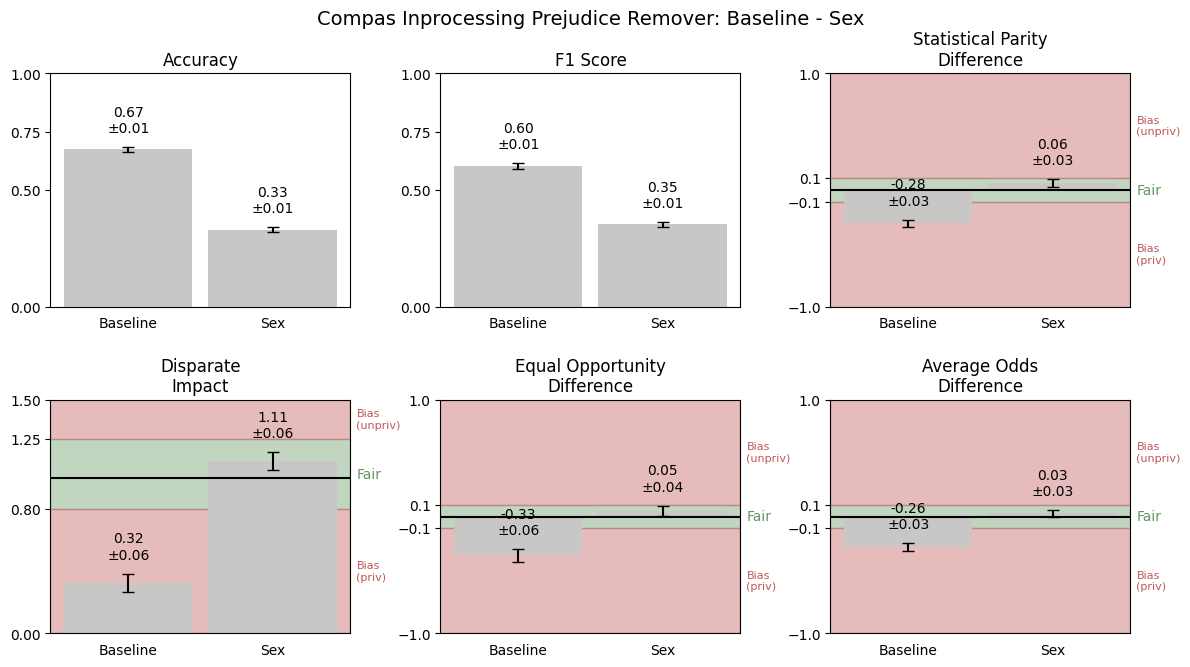

In [5]:
plot_title = 'Compas Inprocessing Prejudice Remover: Baseline - Sex'
fig = compare_viz_metrics_2x3(baseline_sex_agg, compas_sex_metrics_agg, 'Baseline', 'Sex', plot_title)
fname    = plot_title.replace(' ', '_').replace('(', '').replace(')', '')
out_path = os.path.join(out_dir_plots, f'{fname}.png')
fig.savefig(out_path)
fig.show()

## default prejudice remover, race

In [6]:
# 1) Load data
protected          = 'race'
privileged_value   = 0.0
unprivileged_value = 1.0

ds, df = load_compas_race()  
favorable = ds.favorable_label     
unfavorable = ds.unfavorable_label
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Run experiment and evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred = prejudice_remover_train_and_predict(
    df, train_idx, test_idx,
    protected, privileged_value, unprivileged_value,
    favorable, unfavorable)
 
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
compas_race_metrics     = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean', 'std'])
print(compas_race_metrics_agg)

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.344338  0.425689  0.135531  1.211658  0.189504  0.122098
std   0.011548  0.016880  0.039168  0.066121  0.051975  0.039752


/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_97895/2822343715.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


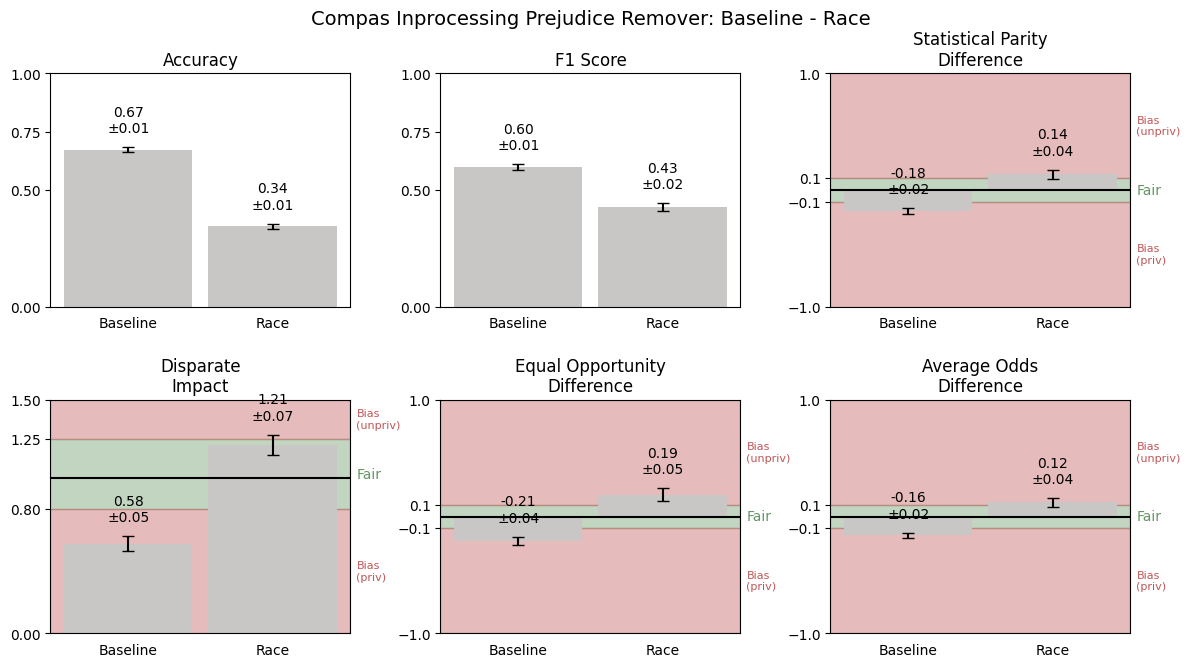

In [7]:
plot_title = 'Compas Inprocessing Prejudice Remover: Baseline - Race'
fig = compare_viz_metrics_2x3(baseline_race_agg, compas_race_metrics_agg, 'Baseline', 'Race', plot_title)
fname    = plot_title.replace(' ', '_').replace('(', '').replace(')', '')
out_path = os.path.join(out_dir_plots, f'{fname}.png')
fig.savefig(out_path)
fig.show()

# ---------------

In [8]:
# 1) Save the aggregated metrics 
save_agg_metrics(
    dataset_name      = dataset_name,
    mitigation_name   = mitigation_name,
    race_agg_df       = compas_race_metrics_agg,
    sex_agg_df        = compas_sex_metrics_agg,
    pipeline_stage    = pipeline_stage   
)

# 2) Save the raw metrics
save_raw_metrics(
    dataset_name      = dataset_name,
    mitigation_name   = mitigation_name,
    race_raw_df       = compas_race_metrics,
    sex_raw_df        = compas_sex_metrics,
    pipeline_stage    = pipeline_stage
)